In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 날씨 데이터세트

In [2]:
# data_path = '/content/drive/MyDrive/Colab_Timeseries/data/sample.csv'
data_path = '/content/drive/MyDrive/Colab_Architecture/data/ASOS_108_20090101_20161231.csv'
_null_df = pd.read_csv(data_path)
null_df = _null_df.drop(columns=['Unnamed: 0'])
df = null_df.interpolate()
df.drop(columns=['rnum', 'stnId', 'stnNm'], inplace=True)
date_time = pd.to_datetime(df.pop('tm'), format='%Y-%m-%d %H:%M')

In [3]:
is_null = df.isnull().sum().sum()
if not is_null:
    display(df.head())
else:
    print("결측치가 완전히 처리되지 않았습니다.")

,ta,rn,ws,wd,hm,pv,td,pa,ps,ss,icsr
0,-7.6,0.0,2.1,290.0,55.0,1.9,-15.0,1013.7,1024.9,0.0,0.0
1,-7.8,0.0,2.3,320.0,54.0,1.8,-15.5,1013.7,1024.9,0.0,0.0
2,-8.1,0.0,2.0,340.0,52.0,1.7,-16.2,1013.8,1025.1,0.0,0.0
3,-8.5,0.0,2.4,290.0,52.0,1.7,-16.6,1014.2,1025.5,0.0,0.0
4,-8.8,0.0,2.1,320.0,53.0,1.7,-16.6,1014.3,1025.6,0.0,0.0


In [4]:
date_time

0       2009-01-01 00:00:00
1       2009-01-01 01:00:00
2       2009-01-01 02:00:00
3       2009-01-01 03:00:00
4       2009-01-01 04:00:00
                ...        
70122   2016-12-31 19:00:00
70123   2016-12-31 20:00:00
70124   2016-12-31 21:00:00
70125   2016-12-31 22:00:00
70126   2016-12-31 23:00:00
Name: tm, Length: 70127, dtype: datetime64[ns]

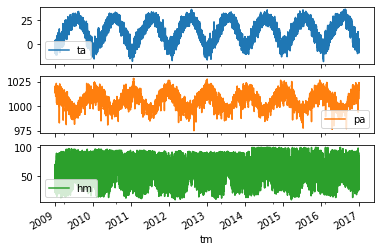

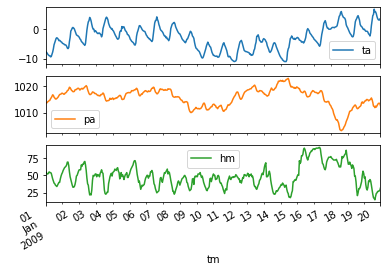

In [5]:
plot_cols = ['ta', 'pa', 'hm']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 검사 및 정리하기

다음으로 데이터세트의 통계를 살펴봅니다.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ta,70127.0,12.822554,11.191880,-18.0,3.5,14.0,22.60,36.40
rn,70127.0,0.160988,1.380714,0.0,0.0,0.0,0.00,71.00
ws,70127.0,2.612271,1.413425,0.0,1.6,2.4,3.40,11.40
wd,70127.0,190.800676,109.928402,0.0,70.0,230.0,290.00,360.00
hm,70127.0,60.251073,19.864594,9.0,45.0,60.0,76.00,100.00
pv,70127.0,11.214524,8.117957,0.6,4.2,9.1,17.30,35.40
td,70127.0,4.525626,12.352965,-28.3,-5.2,5.6,15.20,26.90
pa,70127.0,1005.839323,8.024067,975.1,999.6,1006.0,1012.10,1028.20
ps,70127.0,1016.114898,8.443696,984.4,1009.5,1016.2,1022.70,1039.60
ss,70127.0,0.255317,0.407925,0.0,0.0,0.0,0.60,1.00


### 특성 엔지니어링

모델을 본격적으로 빌드하기 전에 데이터를 이해하고 모델에 적절한 형식의 데이터를 전달하는 것이 중요합니다.

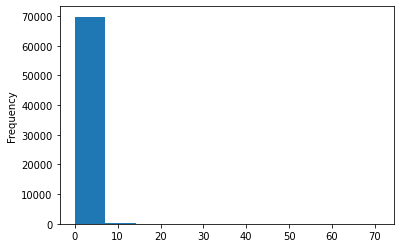

In [7]:
df['rn'].plot.hist()
plt.show()

#### 바람

데이터의 마지막 열인 `wd (deg)`는 도 단위로 바람의 방향을 나타냅니다. 각도가 있으면 모델 입력으로 좋지 않으므로 360°와 0°는 서로 가까워야 하며 부드럽게 휘어져야 합니다. 바람이 불지 않으면 방향은 중요하지 않습니다.

현재, 바람 데이터의 분포는 다음과 같습니다.

Text(0, 0.5, 'Wind Velocity [m/s]')

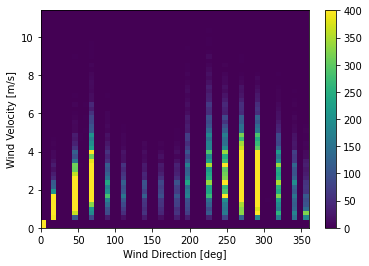

In [8]:
plt.hist2d(df['wd'], df['ws'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

그러나 풍향과 속도 열을 바람 **벡터**로 변환하면 모델이 해석하기가 더 쉽습니다.

In [9]:
wv = df.pop('ws')

# Convert to radians.
wd_rad = df.pop('wd')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

바람 벡터의 분포는 모델이 올바르게 해석하기에 훨씬 더 간단합니다.

(-10.712495876959357,
 7.8934180146016315,
 -10.712495876959357,
 10.14868030448781)

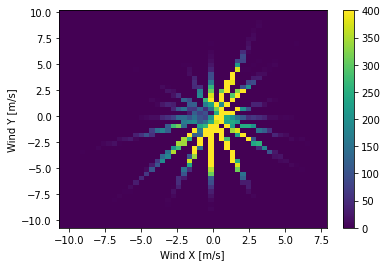

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 시간

마찬가지로 `Date Time` 열은 매우 유용하지만 이 문자열 형식으로는 유용하지 않습니다. 우선 초로 변환합니다.

In [11]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [12]:
timestamp_s

0        1.230768e+09
1        1.230772e+09
2        1.230775e+09
3        1.230779e+09
4        1.230782e+09
             ...     
70122    1.483211e+09
70123    1.483214e+09
70124    1.483218e+09
70125    1.483222e+09
70126    1.483225e+09
Name: tm, Length: 70127, dtype: float64

풍향과 유사하게 초 단위의 시간은 유용한 모델 입력이 아닙니다. 날씨 데이터이므로 하루 및 연 단위의 주기성이 명확합니다. 주기성을 처리할 수 있는 방법에는 여러 가지가 있습니다.

사용 가능한 신호로 변환하는 간단한 방법은 `sin` 및 `cos`를 사용하여 시간을 명확한 "하루 중 시간" 및 "연중 시간" 신호로 변환하는 것입니다.

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

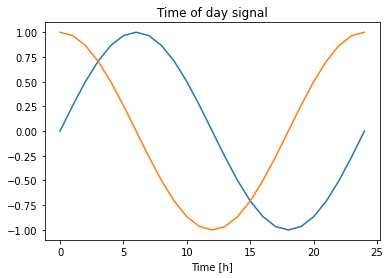

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of year signal')

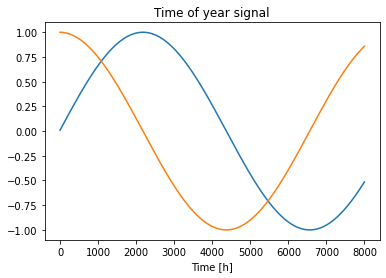

In [15]:
plt.plot(np.array(df['Year sin'])[:8000])
plt.plot(np.array(df['Year cos'])[:8000])
plt.xlabel('Time [h]')
plt.title('Time of year signal')

그러면 모델이 가장 중요한 빈도 특성에 액세스할 수 있습니다. 이 경우 어떤 빈도가 중요한지 미리 알고 있었습니다.

모르는 경우 `fft`를 사용하여 중요한 빈도를 결정할 수 있습니다. 시간에 따른 온도의 `tf.signal.rfft`를 보면 여기서 가정한 내용이 확인됩니다. `1/year` 및 `1/day` 근처에서 빈도 피크가 확실하다는 것을 알 수 있습니다. 

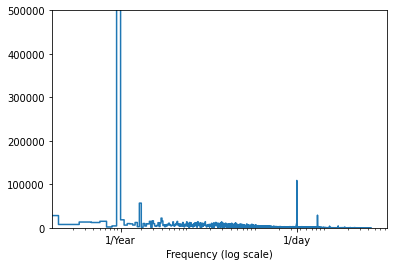

In [16]:
fft = tf.signal.rfft(df['ta'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['ta'])
hours_per_year = 24*365.2524
# hours_per_year = 24*365
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 5e+5)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [17]:
df = df[['Year sin', 'Year cos', 'Day sin', 'Day cos', 'ta', 'rn', 'hm', 'pv', 
        'td', 'pa', 'ps', 'ss', 'icsr', 'Wx', 'Wy']]
if True:
    df.drop(columns=['rn'], inplace=True)

In [18]:
df.head()

,Year sin,Year cos,Day sin,Day cos,ta,hm,pv,td,pa,ps,ss,icsr,Wx,Wy
0,0.009332,0.999956,-1.776611e-12,1.000000,-7.6,55.0,1.9,-15.0,1013.7,1024.9,0.0,0.0,0.718242,-1.973355
1,0.010049,0.999950,2.588190e-01,0.965926,-7.8,54.0,1.8,-15.5,1013.7,1024.9,0.0,0.0,1.761902,-1.478412
2,0.010766,0.999942,5.000000e-01,0.866025,-8.1,52.0,1.7,-16.2,1013.8,1025.1,0.0,0.0,1.879385,-0.684040
3,0.011483,0.999934,7.071068e-01,0.707107,-8.5,52.0,1.7,-16.6,1014.2,1025.5,0.0,0.0,0.820848,-2.255262
4,0.012199,0.999926,8.660254e-01,0.500000,-8.8,53.0,1.7,-16.6,1014.3,1025.6,0.0,0.0,1.608693,-1.349854


### 데이터 분할

훈련, 검증 및 테스트 세트에 `(70%, 20%, 10%)` 분할을 사용합니다. 분할하기 전에 데이터가 임의로 셔플되지 **않습니다**. 이것은 두 가지 이유 때문입니다.

1. 데이터를 연속된 샘플의 창으로 자르는 것이 여전히 가능합니다.
2. 모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적입니다.

In [19]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [20]:
num_features

14

### 데이터 정규화

신경망을 훈련하기 전에 특성의 크기를 정하는 것이 중요합니다. 정규화는 이 크기 조정을 수행하는 일반적인 방법입니다. 평균을 빼고 각 특성의 표준 편차로 나눕니다.

모델이 검증 및 테스트 세트의 값에 액세스할 수 없도록 훈련 데이터를 사용해서만 평균 및 표준 편차를 계산해야 합니다.

또한 모델이 훈련할 때 훈련 세트의 미래 값에 액세스할 수 없어야 하고 이 정규화가 이동 평균을 사용하여 수행되어야 한다고 말할 수도 있습니다. 이 내용은 본 튜토리얼의 중점 사항이 아니며, 검증 및 테스트 세트가 있기 때문에 (다소) 정직한 메트릭을 얻을 수 있습니다. 따라서 단순화를 위해 이 튜토리얼에서는 단순 평균을 사용합니다.

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

이제 특성의 분포를 살펴봅니다. 일부 특성은 꼬리가 길지만 `-9999` 풍속 값과 같은 명백한 오류는 없습니다.

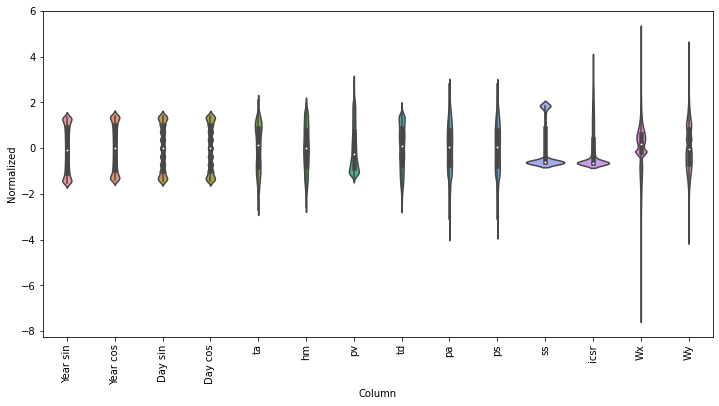

In [22]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

####WindowGenerator

In [23]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

이 섹션의 시작 부분에서 다이어그램에 나타낸 두 개의 창을 만드는 코드는 다음과 같습니다.

In [24]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['ta'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['ta']

In [25]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['ta'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['ta']

####split_window

In [26]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

# 클래스 정의 이후 메서드 추가
# https://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance
WindowGenerator.split_window = split_window

다음을 사용해 보세요.

In [27]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 14)
Inputs shape: (3, 6, 14)
labels shape: (3, 1, 1)


일반적으로 TensorFlow의 데이터는 가장 바깥 쪽 인덱스가 여러 예제("배치" 차원)에 걸쳐 있는 배열로 구성됩니다. 중간 인덱스는 "시간" 또는 "공간"(너비, 높이) 차원입니다. 가장 안쪽 인덱스는 특성입니다.

위의 코드는 두 배치의 7-타임스텝 창을 사용하며 각 타임스텝에는 19개의 특성이 있습니다. 그러면 이것을 한 배치의 6-타임스텝과 19개의 특성 입력 및 1-타임스텝 1-특성 레이블로 분할합니다. 레이블에는 하나의 특성만 있는데, `WindowGenerator`가 `label_columns=['T (degC)']`로 초기화되었기 때문입니다. 우선 이 튜토리얼에서는 단일 출력 레이블을 예측하는 모델을 빌드합니다.

In [28]:
w2.input_slice, w2.labels_slice, w1.input_slice, w1.labels_slice

(slice(0, 6, None),
 slice(6, None, None),
 slice(0, 24, None),
 slice(47, None, None))

In [29]:
np.arange(w2.total_window_size)[w2.input_slice], \
np.arange(w2.total_window_size)[w2.labels_slice], \
np.arange(w1.total_window_size)[w1.input_slice], \
np.arange(w1.total_window_size)[w1.labels_slice] 

(array([0, 1, 2, 3, 4, 5]),
 array([6]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([47]))

### 3. 플롯하기

다음은 분할 창을 간단하게 시각화할 수 있는 플롯 메서드입니다.

In [30]:
w2.example = example_inputs, example_labels

In [31]:
def plot(self, model=None, plot_col='ta', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

이 플롯은 항목이 참조하는 시간을 기준으로 입력, 레이블 및 (나중에) 예측값을 정렬합니다.

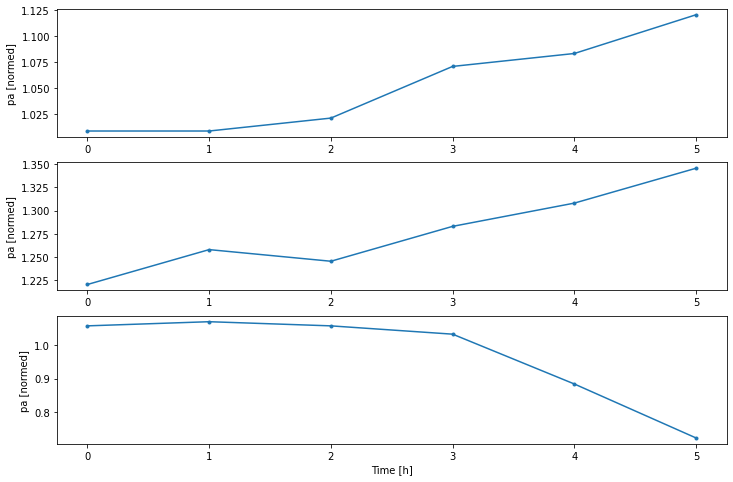

In [32]:
w2.plot(plot_col='pa')

다른 열을 플롯할 수 있지만 예제 창 `w2` 구성에는 `T (degC)` 열에 대한 레이블만 있습니다.

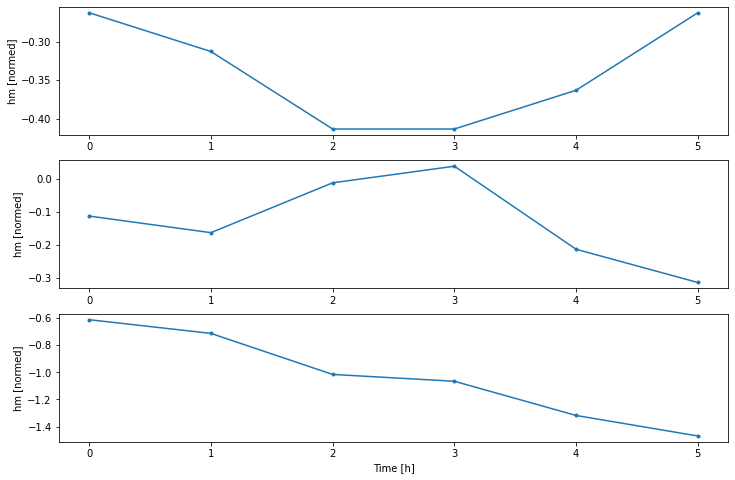

In [33]:
w2.plot(plot_col='hm')

### 4. `tf.data.Dataset` 만들기

마지막으로, 이 `make_dataset` 메서드는 시계열 `DataFrame`을 가져와 `preprocessing.timeseries_dataset_from_array` 함수를 이용해 `(input_window, label_window)` 쌍의 `tf.data.Dataset`로 변환합니다.

#### make_dataset

####tf.Dataset.map(function)

#### tf.keras.preprocessing.timeseries_dataset_from_array

In [34]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 객체는 훈련, 검증 및 테스트 데이터를 보유합니다. 위의 

---

`make_dataset` 메서드를 사용하여 `tf.data.Datasets`로 여기에 액세스하기 위한 

---

특성을 추가합니다. 또한 간편한 액세스와 플롯을 위한 표준 예제 배치를 추가합니다.

In [35]:
data = test_df
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=w2.total_window_size,
    sequence_stride=1,
    shuffle=True,
    batch_size=32,)

In [36]:
i = 0
for data in ds:
    input, target = w2.split_window(data)
    if not i:
        print(input.shape, target.shape)
    i += 1
print(f'total iteration: {i}')

(32, 6, 14) (32, 1, 1)
total iteration: 219


In [37]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

이제 `WindowGenerator` 객체가 `tf.data.Dataset` 객체에 대한 액세스 권한을 부여하므로 데이터를 쉽게 반복할 수 있습니다.

`Dataset.element_spec` 속성은 데이터세트 요소의 구조, `dtypes` 및 형상을 알려줍니다.

#### tf.Dataset.element_spec

In [38]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 14), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

`Dataset`를 반복하면 구체적인 배치가 생성됩니다.

#### tf.Dataset.take(counts)

In [39]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 14)
Labels shape (batch, time, features): (32, 1, 1)


## 단일 스텝 모델

이러한 종류의 데이터를 기반으로 빌드할 수 있는 가장 간단한 모델은 현재 조건에만 기초하여 미래로 1 타임스텝(1시간) 진행된 단일 특성 값을 예측하는 모델입니다.

따라서 1시간 미래의 `T (degC)` 값을 예측하는 모델을 빌드하는 것으로 시작하겠습니다.

![Predict the next time step](https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png)

다음과 같은 단일 스텝 `(input, label)` 쌍을 생성하도록 `WindowGenerator` 객체를 구성합니다.

In [40]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, 
    label_columns=['ta'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ta']

In [41]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 14)
Labels shape (batch, time, features): (32, 1, 1)


### 기준

훈련 가능한 모델을 빌드하기 전에 나중에 더 복잡한 모델과 비교하기 위한 포인트로 성능 기준을 갖는 것이 좋습니다.

첫 번째 작업은 모든 특성의 현재 값을 고려하여 1시간 미래의 온도를 예측하는 것입니다. 현재 값에는 현재 온도가 포함됩니다.

따라서 예측으로 현재 온도를 반환하여 "변화 없음"을 예측하는 모델로 시작하겠습니다. 온도는 천천히 변하기 때문에 이것은 합리적인 기준입니다. 물론, 더 미래로 들어가면 이 기준의 예측 효과는 떨어질 것입니다.

![Send the input to the output](https://www.tensorflow.org/tutorials/structured_data/images/baseline.png)

In [42]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [43]:
baseline = Baseline(label_index=column_indices['ta'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0633


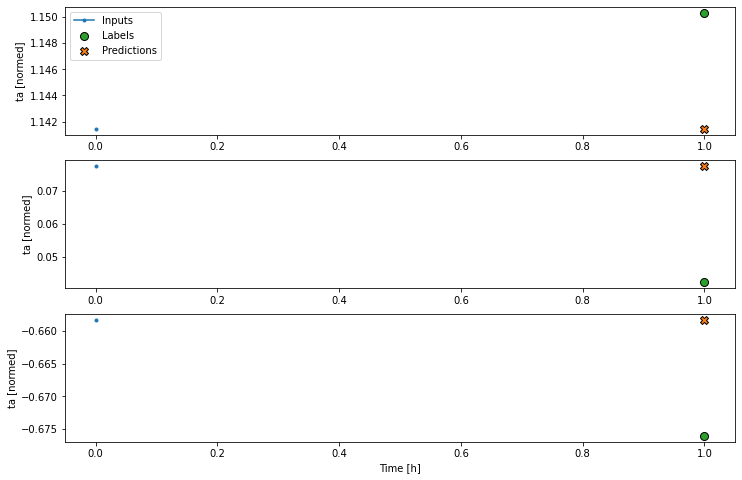

In [44]:
single_step_window.plot(baseline)

몇 가지 성능 메트릭을 출력했지만 모델이 얼마나 잘 동작하는지에 대한 느낌은 주지 않습니다.

`WindowGenerator`에는 플롯 메서드가 있지만 단일 샘플만으로는 플롯이 그다지 흥미롭지 않습니다. 따라서 한 번에 24시간 범위의 연속 입력과 레이블을 생성하는 더 넓은 `WindowGenerator`를 만듭니다.

`wide_window`는 모델이 동작하는 방식을 변화시키지 않습니다. 이 모델은 단일 입력 타임스텝을 기반으로 1시간 미래를 예측합니다. 여기서 `time` 축은 `batch` 축과 같은 역할을 합니다. 각 예측은 타임스텝 사이의 상호 작용 없이 독립적으로 이루어집니다.

In [45]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['ta'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['ta']

이 확장된 창은 어떠한 코드 변경 없이 동일한 `baseline` 모델에 직접 전달할 수 있습니다. 이는 입력과 레이블이 동일한 수의 타임스텝을 가지며 기준이 입력을 출력으로 전달하기 때문에 가능합니다.

![One prediction 1h into the future, ever hour.](https://www.tensorflow.org/tutorials/structured_data/images/last_window.png)

In [46]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 14)
Output shape: (32, 1, 1)


In [47]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


기준 모델의 예측값을 플롯하면 1시간씩 오른쪽으로 이동한 단순한 레이블임을 알 수 있습니다.

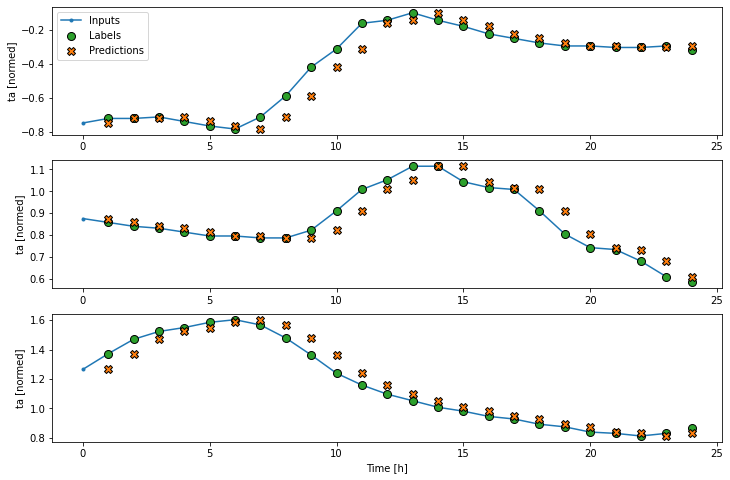

In [48]:
wide_window.plot(baseline)

위의 세 가지 예제 플롯에서 단일 스텝 모델은 24시간 동안 실행됩니다. 이에 관해 몇 가지 설명이 필요합니다.

- 파란색 "입력" 라인은 각 타임스텝의 입력 온도를 보여줍니다. 이 모델은 모든 특성을 수신하며 이 플롯은 온도만 표시합니다.
- 녹색 "레이블" 점은 목표 예측값을 나타냅니다. 이러한 점은 입력 시간이 아니라 예측 시간에 표시됩니다. 레이블의 범위가 입력에 상대적으로 한 스텝 이동하는 이유가 여기에 있습니다.
- 주황색 "예측" 십자는 각 출력 타임스텝에 대한 모델의 예측입니다. 모델이 완벽하게 예측하는 경우 예측값은 "레이블" 바로 위에 놓여집니다.

### 선형 모델

이 작업에 적용할 수 있는 가장 간단한 **훈련 가능한** 모델은 입력과 출력 사이에 선형 변환을 삽입하는 것입니다. 이 경우 타임스텝의 출력은 해당 스텝에만 의존합니다.

![A single step prediction](https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png)

`activation` 세트가 없는 `layers.Dense`는 선형 모델입니다. 레이어는 데이터의 마지막 축을 `(batch, time, inputs)`에서 `(batch, time, units)`로만 변환하며, `batch` 및 `time` 축의 모든 항목에 독립적으로 적용됩니다.

In [49]:
linear = tf.keras.Sequential([
                              tf.keras.layers.Dense(units=1)
])

In [50]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 14)
Output shape: (32, 1, 1)


In [51]:
# Saving layer weights at each epoch
# https://stackoverflow.com/questions/44938160/saving-layer-weights-at-each-epoch-during-training-into-a-numpy-type-array-conv
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        logs = logs or {}
        self.epoch.append(epoch)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        modelWeights = []
        for layer in model.layers:
            layerWeights = []
            for weight in layer.get_weights():
                layerWeights.append(weight)
            modelWeights.append(layerWeights)
        self.weights.append(modelWeights)

In [52]:
weight_list = []

In [53]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_weight = self.model.layers[0].kernel[:, 0].numpy()
        weight_list.append(epoch_weight)

In [54]:
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping,
                                #    CustomCallback(model),
                                   ])
    return history

In [55]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.2494 - mean_absolute_error: 0.3220 - val_loss: 0.0268 - val_mean_absolute_error: 0.1308
Epoch 2/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0138 - mean_absolute_error: 0.0930 - val_loss: 0.0071 - val_mean_absolute_error: 0.0652
Epoch 3/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0484 - val_loss: 0.0038 - val_mean_absolute_error: 0.0456
Epoch 4/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0413 - val_loss: 0.0036 - val_mean_absolute_error: 0.0450
Epoch 5/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0413 - val_loss: 0.0036 - val_mean_absolute_error: 0.0448
Epoch 6/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0413 - val_loss: 0.0036 - val_mean_absolute_error: 0.0447
Epoc

In [56]:
# CustomCallback 호출시에 저장된 가중치의 변화 그래프를 출력
if False:
    df = pd.DataFrame(_weights)
    _weights = np.array(weight_list)
    df.plot()
    plt.legend(train_df.columns, )
    plt.show()

In [57]:
val_performance['Linear'] = linear.evaluate(single_step_window.val, verbose=2)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=2)

439/439 - 1s - loss: 0.0036 - mean_absolute_error: 0.0446
220/220 - 1s - loss: 0.0037 - mean_absolute_error: 0.0445


`baseline` 모델과 마찬가지로 선형 모델은 넓은 범위의 배치에서 호출할 수 있습니다. 이러한 방식으로 모델은 연속적인 타임스텝에 대해 일련의 독립적인 예측을 수행합니다. `time` 축은 다른 `batch` 축처럼 작동합니다. 각 타임스텝에서 예측 사이에 상호 작용은 없습니다.

![A single step prediction](https://www.tensorflow.org/tutorials/structured_data/images/wide_window.png)

In [58]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


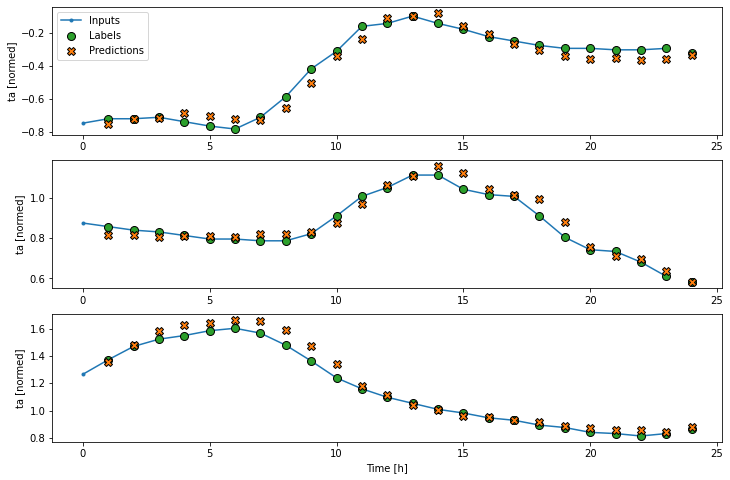

In [59]:
wide_window.plot(linear)

In [60]:
# baseline model evaluation
loss, mae = baseline.evaluate(wide_window.test)
# linear model evaluation
loss, mae = linear.evaluate(wide_window.test)

219/219 [==============================] - 1s 4ms/step - loss: 0.0037 - mean_absolute_error: 0.0445


#### tf.keras.Model.`layers.kernel`

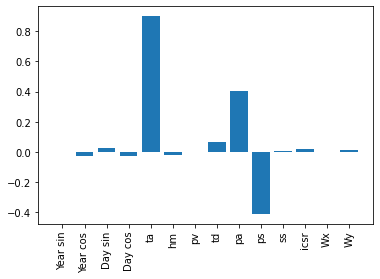

In [61]:
bar_y = linear.layers[0].kernel[:, 0].numpy()
bar_x = range(len(train_df.columns))
plt.bar(x=bar_x, height=bar_y)
axis = plt.gca()
axis.set_xticks(bar_x)  
_ = axis.set_xticklabels(train_df.columns, rotation=90)

때로 모델은 입력 `T (degC)`에 가장 많은 가중치를 두지 않습니다. 이것은 무작위 초기화의 위험 중 하나입니다. 

### 밀집

실제로 여러 타임스텝에서 동작하는 모델을 적용하기 전에 더 깊고 강력한 단일 입력 스텝 모델의 성능을 확인하는 것이 좋습니다.

다음 모델은 입력과 출력 사이에 몇 개의 `Dense` 레이어를 쌓는다는 점을 제외하면 `linear` 모델과 유사합니다. 

In [62]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [63]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/20
1534/1534 [==============================] - 9s 5ms/step - loss: 0.0092 - mean_absolute_error: 0.0582 - val_loss: 0.0034 - val_mean_absolute_error: 0.0445
Epoch 2/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0396 - val_loss: 0.0026 - val_mean_absolute_error: 0.0383
Epoch 3/20
1534/1534 [==============================] - 8s 6ms/step - loss: 0.0026 - mean_absolute_error: 0.0377 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397
Epoch 4/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0359 - val_loss: 0.0031 - val_mean_absolute_error: 0.0417


In [64]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

220/220 [==============================] - 1s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0394


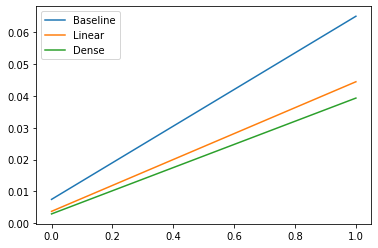

In [65]:
pd.DataFrame(performance).plot()
plt.show()

### 다중 스텝 밀집

단일 타임스텝 모델에는 입력의 현재 값에 대한 컨텍스트가 없습니다. 시간에 따라 입력 특성이 어떻게 변하는지 볼 수 없습니다. 이 문제를 해결하려면 모델이 예측을 수행할 때 여러 타임스텝에 액세스해야 합니다.

![Three time steps are used for each prediction.](https://www.tensorflow.org/tutorials/structured_data/images/conv_window.png)


`baseline` , `linear` 및 `dense` 모델은 각 타임스텝을 독립적으로 처리했습니다. 여기서 모델은 단일 출력을 생성하기 위해 여러 타임스텝을 입력으로 사용합니다.

3시간의 입력과 1시간의 레이블 배치를 생성하는 `WindowGenerator`를 만듭니다.

`Window`의 `shift` 매개변수는 두 창의 끝에 상대적입니다.


In [66]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ta']
)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['ta']

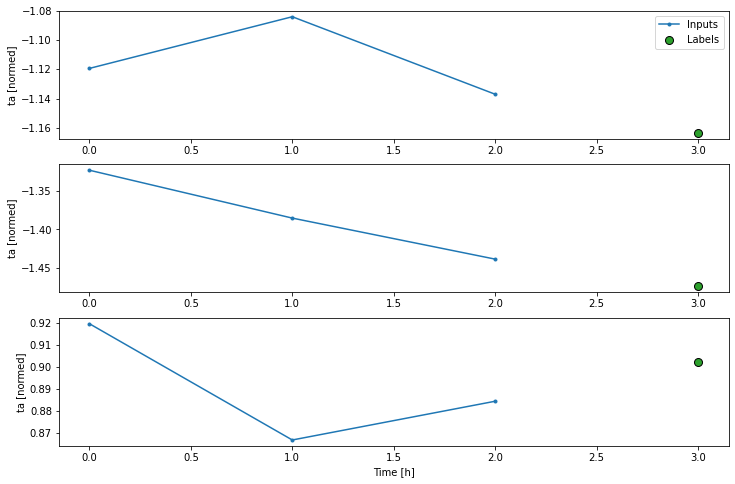

In [67]:
conv_window.plot()

`layers.Flatten`을 모델의 첫 번째 레이어로 추가하여 다중 입력 스텝 창에서 `dense` 모델을 훈련할 수 있습니다.

In [68]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([-1, 1])
])

In [69]:
def print_shape(self, model):
    print('Input shape:', self.example[0].shape)
    print('Output shape:', model(self.example[0]).shape)
    
WindowGenerator.print_shape = print_shape

In [70]:
history = compile_and_fit(window=conv_window, model=multi_step_dense)
IPython.display.clear_output()

In [71]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

439/439 [==============================] - 2s 3ms/step - loss: 0.0032 - mean_absolute_error: 0.0417


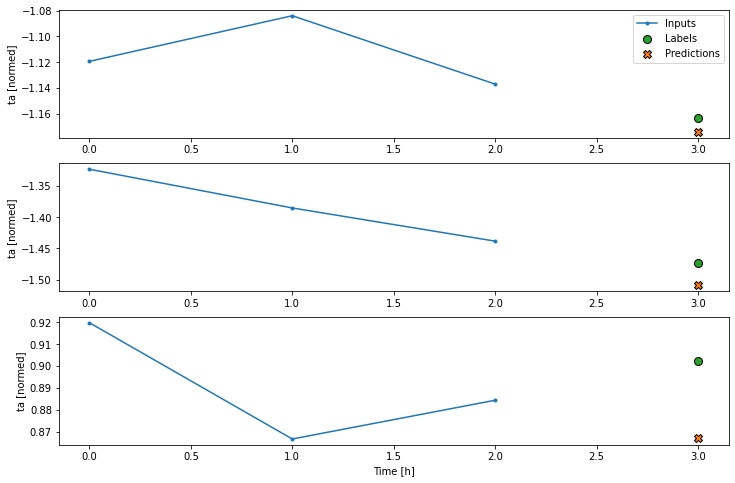

In [72]:
conv_window.plot(multi_step_dense)

### 컨볼루션 신경망

컨볼루션 레이어(`layers.Conv1D`)도 각 예측에 대한 입력으로 여러 타임스텝을 사용합니다.

다음은 컨볼루션으로 다시 작성한 `multi_step_dense`와 **동일한** 모델입니다.

다음 변경 사항에 주목하세요.

- `layers.Flatten`과 첫 번째 `layers.Dense`는 `layers.Conv1D`로 대체됩니다.
- 컨볼루션이 출력에서 시간 축을 유지하므로 `layers.Reshape`는 이 더 이상 필요하지 않습니다.

In [73]:
conv_model = tf.keras.Sequential(
    name='conv_model',
    layers=[
           tf.keras.layers.Conv1D(filters=32,
                                  kernel_size=(CONV_WIDTH),
                                  activation='relu'),
           tf.keras.layers.Dense(units=32, activation='relu'),
           tf.keras.layers.Dense(units=1),
    ]
)

In [74]:
conv_window.print_shape(conv_model)

Input shape: (32, 3, 14)
Output shape: (32, 1, 1)


In [75]:
history = compile_and_fit(model=conv_model, window=conv_window)
IPython.display.clear_output()

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test)

220/220 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0325


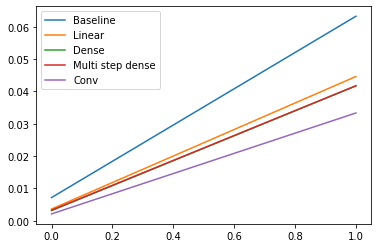

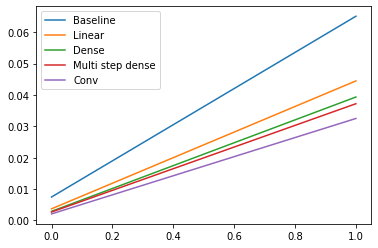

In [77]:
pd.DataFrame(val_performance).plot()
pd.DataFrame(performance).plot()
plt.show()

이 `conv_model`과 `multi_step_dense` 모델의 차이점은 `conv_model`은 모든 길이의 입력에서 실행될 수 있다는 것입니다. 컨볼루셔널 레이어는 입력의 슬라이딩 윈도우에 적용됩니다.

![Executing a convolutional model on a sequence](https://www.tensorflow.org/tutorials/structured_data/images/wide_conv_window.png)

더 넓은 입력에서 실행하면 더 넓은 출력이 생성됩니다.

In [79]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 14)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [122]:
# Conv1D test cell
sample_X = np.array([0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=np.float32)
sample_X = sample_X.reshape(1, len(sample_X), 1)
model = tf.keras.Sequential([tf.keras.layers.Conv1D(1, 3)])
print(model(sample_X))
model.layers[0].kernel.numpy().flatten()#.sum()

tf.Tensor(
[[[ 0.        ]
  [-0.69689965]
  [-0.45857763]
  [ 0.33575702]
  [ 1.0326567 ]
  [ 0.79433465]
  [ 0.        ]]], shape=(1, 7, 1), dtype=float32)


array([ 0.79433465,  0.23832202, -0.69689965], dtype=float32)

출력은 입력보다 짧습니다. 훈련 또는 플롯 작업을 수행하려면 레이블과 예상의 길이가 동일해야 합니다. 따라서 레이블과 예측 길이가 일치하도록 몇 개의 추가 입력 타임스텝으로 넓은 창을 생성하는 `WindowGenerator`를 빌드합니다. 

In [125]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ta'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['ta']

In [126]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 14)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


이제 더 넓은 창에 모델의 예측값을 플롯할 수 있습니다. 첫 번째 예측 전 3개의 입력 타임스텝에 주목하세요. 여기서 모든 예측은 이전 3개의 타임스텝에 기초합니다.

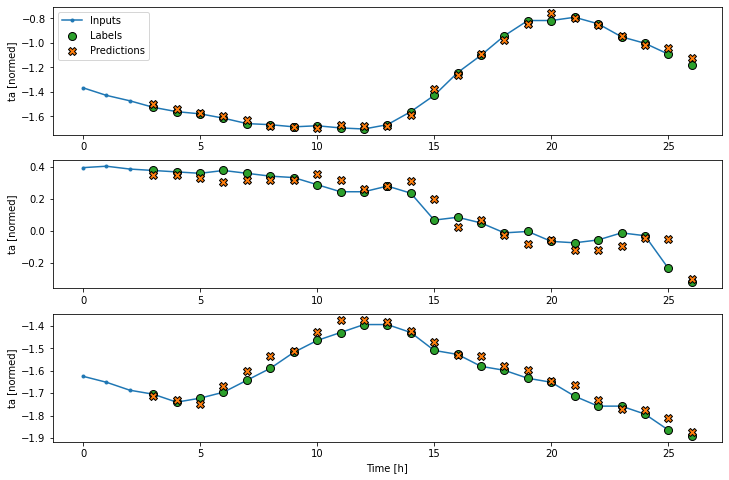

In [127]:
wide_conv_window.plot(conv_model)

### 순환 신경망

Recurrent Neural Network(RNN)는 시계열 데이터에 적합한 신경망 유형입니다. RNN은 시계열을 단계별로 처리하여 타임스텝 사이에서 내부 상태를 유지합니다.

자세한 내용은 [텍스트 생성 튜토리얼](https://www.tensorflow.org/tutorials/text/text_generation) 또는 [RNN 가이드](https://www.tensorflow.org/guide/keras/rnn)를 읽어보세요.

이 튜토리얼에서는 [Long Short Term Memory](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)(LSTM)이라는 RNN 레이어를 사용합니다.

모든 keras RNN 레이어에 대한 중요한 생성자 인수는 `return_sequences` 인수입니다. 이 설정은 다음 두 가지 방법 중 하나로 레이어를 구성할 수 있습니다.

1. 기본값인 `False`인 경우 레이어는 최종 타임스텝의 출력만 반환하여 단일 예측을 수행하기 전에 모델이 내부 상태를 준비할 시간을 줍니다.

![An lstm warming up and making a single prediction](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)

1. `True`이면 레이어가 각 입력에 대한 출력을 반환합니다. 다음과 같은 경우에 유용합니다.

- RNN 레이어 쌓기
- 여러 타임스텝에서 동시에 모델 훈련

![An lstm making a prediction after every timestep](https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png)

In [128]:
lstm_model = tf.keras.Sequential(
    name='lstm_model',
    layers=[
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(32, return_sequences=True),
            # Shape => [batch, time, feautres]
            tf.keras.layers.Dense(1)
    ]
)

`return_sequences=True`이면 모델을 한 번에 24시간 분량 데이터에 대해 훈련할 수 있습니다.

참고: 이 경우에는 모델 성능의 관점에서 기대할 것이 없습니다. 첫 번째 타임스텝에서 모델이 이전 스텝에 액세스할 수 없으므로 이전에 표시한 단순한 `linear` 및 `dense` 모델보다 더 나을 것이 없기 때문입니다.

In [141]:
wide_window.print_shape(lstm_model)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


In [144]:
for input, target in wide_window.train.take(1):
    output = tf.keras.layers.LSTM(32, return_sequences=True)(input)
    print(output.shape)

(32, 24, 32)


In [158]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 32)            6016      
_________________________________________________________________
dense_9 (Dense)              (None, 24, 1)             33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [130]:
history = compile_and_fit(model=lstm_model, window=wide_window)
IPython.display.clear_output()

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

219/219 [==============================] - 1s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0302


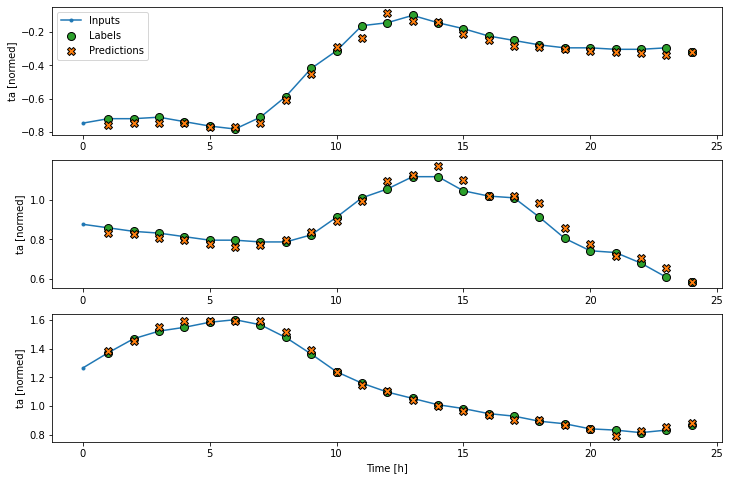

In [131]:
wide_window.plot(lstm_model)

### 성능

이 데이터세트를 사용하면 일반적으로 각 모델의 성능이 이전 모델보다 약간 더 좋습니다.

In [137]:
single_val_performance = val_performance
single_performance = performance

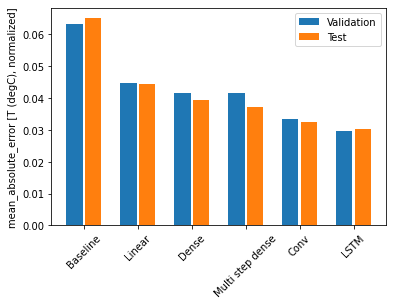

In [138]:
x = np.arange(len(single_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in single_val_performance.values()]
test_mae = [v[metric_index] for v in single_performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=single_performance.keys(),
           rotation=45)
_ = plt.legend()

In [133]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0651
Linear      : 0.0445
Dense       : 0.0394
Multi step dense: 0.0372
Conv        : 0.0325
LSTM        : 0.0302


### 다중 출력 모델

지금까지 모델은 모두 단일 타임스텝에 대해 단일 출력 특성 `T (degC)`를 예측했습니다.

이러한 모든 모델은 간단히 출력 레이어의 단위 수를 변경하고 `labels`에 모든 특성을 포함하도록 훈련 창을 조정하여 여러 특성을 예측하도록 변환할 수 있습니다.


In [136]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # dont't set the `label_columns` argument.
    input_width =1, label_width=1, shift=1
)
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1
)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 14)
Labels shape (batch, time, features): (32, 24, 14)


레이블의 `features` 축은 이제 1이 아닌 입력과 동일한 깊이를 갖습니다.

#### 기준

여기서는 동일한 기준 모델을 사용할 수 있지만 이번에는 특정 `label_index`를 선택하는 대신 모든 특성을 반복합니다.

In [139]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [140]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.1023 - mean_absolute_error: 0.1562


#### 밀집

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu')
])